Sample: 
/Users/ashleefeng/OneDrive - Johns Hopkins/PacBio/20190430_H2/800pM_H2/m190430_162353_42131_c000499122559900001500000112312130_s1_p0.mcd.h5


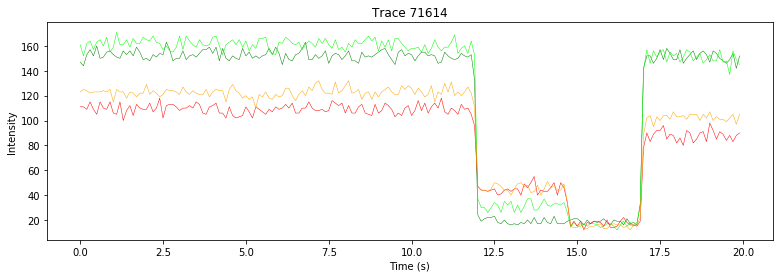

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from time import time
from functions import utils
import os.path as path

sample_file = utils.gui_fname().decode("utf-8")
# background_filename = utils.gui_fname().decode("utf-8")
tokens = sample_file.split('/')
base = path.basename(sample_file)
abs_dir = path.dirname(sample_file)
prefix = base.split('.')[0]
sample_prefix = abs_dir + '/' + prefix
print("Sample: \n%s" %sample_file)
# print("Background: \n%s" %background_filename)

start = time()
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']

#bg_file = open(background_filename, "rb")
#bg = np.loadtxt(bg_file, delimiter=",")

traces = raw_traces
plt.figure(figsize=(13, 4))
traceID = np.random.randint(0, n_traces)
utils.plot_one_trace(raw_traces, traceID, time_axis, range(0, 200), colors)

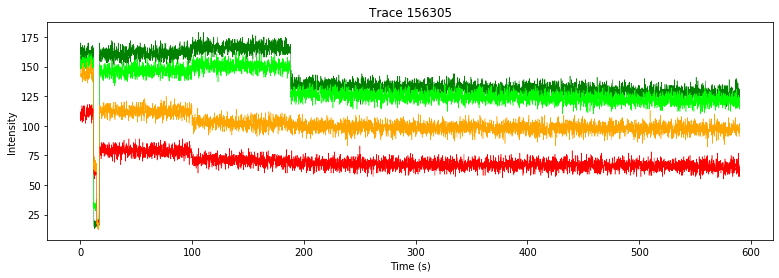

In [45]:
plt.figure(figsize=(13, 4))
traceID = np.random.randint(0, n_traces)
n_frames = raw_traces.shape[2]
utils.plot_one_trace(raw_traces, traceID, time_axis, range(0, n_frames), colors)

In [17]:
foi = range(1000, 1010) # frames of interest
n_frames = len(foi)
sele_frames = np.array(raw_traces[:, :, range(1000, 1010)], dtype=np.uint8)
avg_intens = np.mean(sele_frames, axis=2)

Text(0, 0.5, 'Count')

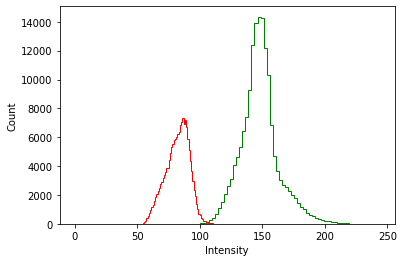

In [18]:
plt.figure()
for i in [0, 2]:
    avg_intens_i = avg_intens.T[i]
    min_i = min(avg_intens_i)
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')

Raw data


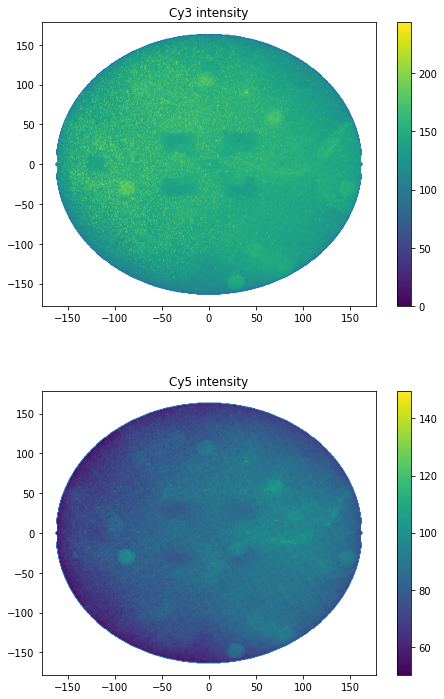

In [20]:
print("Raw data")
plt.figure(figsize=(7.5, 12))
for i in [0, 2]:
    plt.subplot(2, 1, i/2+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
plt.savefig(sample_prefix + '_grid.png')
plt.show()